In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

# HYPOTHESIS TESTING
from scipy.stats import ks_2samp

# Sklearn preprocessing
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor,StackingRegressor,RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_approximation import Nystroem

#notebook settings
sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

# Understanding Abalone Dataset Features

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [3]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
test.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [5]:
def rename_and_lowercase(df):
    df = df.rename(columns = {'Whole weight.1':'shucked weight'})
    df = df.rename(columns = {'Whole weight.2':'viscera weight'})
    df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
    return df

train = rename_and_lowercase(train)
test = rename_and_lowercase(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight'],
       dtype='object'))

In [6]:
# # for better understanding of the data

# # rename Whole weight.1 to shucked weight
# train = train.rename(columns = {'Whole weight.1':'shucked weight'})

# # rename Whole weight.2 to Viscera weight
# train = train.rename(columns = {'Whole weight.2':'viscera weight'})

# # add _ to empty spaces in column names
# train.columns = train.columns.str.replace(' ','_')

# # lower case column names
# train.columns = train.columns.str.lower()

# train.columns

# Feature Engineering

In [7]:
# link about age of abalones
#https://ubc-mds.github.io/abalone_age_classification/README.html

## Age Group:
# Add a classification target columns. If rings > 11, then classified as old
#train["Is old"] = np.where(train["rings"] > 11, "old", "young")

# later might try create a classification model to predict if the abalone is old or young, apply to train and test data
# afterwards use the predicted column as a feature in the regression model for predict rings of the abalone

In [10]:
def apply_transformations(train, test):
    # Dimension Ratios:
    train['length_diameter_ratio'] = train['length'] / train['diameter']
    train['height_diameter_ratio'] = train['height'] / train['diameter']
    test['length_diameter_ratio'] = test['length'] / test['diameter']
    test['height_diameter_ratio'] = test['height'] / test['diameter']

    ## Volume:
    train['volume'] = (4/3) * np.pi * (train['length']/2) * (train['diameter']/2) * (train['height']/2)
    test['volume'] = (4/3) * np.pi * (test['length']/2) * (test['diameter']/2) * (test['height']/2)

    ## Shell Thickness:
    train['shell_thickness_to_length'] = (train['whole_weight'] - train['shucked_weight']) / train['length']
    train['shell_thickness_to_diameter'] = (train['whole_weight'] - train['shucked_weight']) / train['diameter']
    test['shell_thickness_to_length'] = (test['whole_weight'] - test['shucked_weight']) / test['length']
    test['shell_thickness_to_diameter'] = (test['whole_weight'] - test['shucked_weight']) / test['diameter']

    ## Interaction Terms:
    train['length_diameter_interact'] = train['length'] * train['diameter']
    train['whole_shell_weight_interact'] = train['whole_weight'] * train['shell_weight']
    test['length_diameter_interact'] = test['length'] * test['diameter']
    test['whole_shell_weight_interact'] = test['whole_weight'] * test['shell_weight']

    ## Polynomial Features:
    train['length_squared'] = train['length'] ** 2
    train['diameter_cubed'] = train['diameter'] ** 3
    test['length_squared'] = test['length'] ** 2
    test['diameter_cubed'] = test['diameter'] ** 3
    
    # Drop columns
    train = train.drop(columns = ['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight'])
    test = test.drop(columns = ['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight'])

    return train, test

In [11]:
train, test = apply_transformations(train, test)

train.columns, test.columns

(Index(['sex', 'rings', 'length_diameter_ratio', 'height_diameter_ratio',
        'volume', 'shell_thickness_to_length', 'shell_thickness_to_diameter',
        'length_diameter_interact', 'whole_shell_weight_interact',
        'length_squared', 'diameter_cubed'],
       dtype='object'),
 Index(['sex', 'length_diameter_ratio', 'height_diameter_ratio', 'volume',
        'shell_thickness_to_length', 'shell_thickness_to_diameter',
        'length_diameter_interact', 'whole_shell_weight_interact',
        'length_squared', 'diameter_cubed'],
       dtype='object'))

In [12]:
def generate_summary_statistics(data):
    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    return summary_table

In [13]:
# summary statistics of train data
generate_summary_statistics(train)

,dtypes,Missing,Unique,Count,Duplicated
sex,object,0,3,90615,110
rings,int64,0,28,90615,110
length_diameter_ratio,float64,0,1742,90615,110
height_diameter_ratio,float64,0,1311,90615,110
volume,float64,0,13696,90615,110
shell_thickness_to_length,float64,0,45373,90615,110
shell_thickness_to_diameter,float64,0,40848,90615,110
length_diameter_interact,float64,0,2393,90615,110
whole_shell_weight_interact,float64,0,46404,90615,110
length_squared,float64,0,157,90615,110


In [14]:
generate_summary_statistics(test)

,dtypes,Missing,Unique,Count,Duplicated
sex,object,0,3,60411,148
length_diameter_ratio,float64,0,1585,60411,148
height_diameter_ratio,float64,0,1232,60411,148
volume,float64,0,11727,60411,148
shell_thickness_to_length,float64,0,35538,60411,148
shell_thickness_to_diameter,float64,0,32316,60411,148
length_diameter_interact,float64,0,2157,60411,148
whole_shell_weight_interact,float64,0,35072,60411,148
length_squared,float64,0,148,60411,148
diameter_cubed,float64,0,130,60411,148


In [15]:
# check the distribution of categorical features
categorical_features = train.select_dtypes(include=['object']).copy()

for col in categorical_features.columns:
    print(f'{col} distribution:')
    print(categorical_features[col].value_counts(normalize=True))
    print('\n')

sex distribution:
sex
I    0.365204
M    0.342405
F    0.292391
Name: proportion, dtype: float64




In [16]:
def choose_scaler_for_features(data):
    """
    Choose the appropriate scaler for each feature in a DataFrame.

    Parameters:
    data (DataFrame): DataFrame containing numerical features.

    Returns:
    dict: Dictionary mapping feature names to recommended scalers.
    """

    # Initialize a dictionary to store recommended scalers for each feature
    scalers = {}

    # Loop through each feature
    for feature in data.columns:
        feature_data = data[feature]

        # Fit data with different scalers
        minmax_scaled = MinMaxScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()
        standard_scaled = StandardScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()
        robust_scaled = RobustScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()

        # Perform Kolmogorov-Smirnov test between original and scaled data
        ks_minmax = ks_2samp(feature_data, minmax_scaled).statistic
        ks_standard = ks_2samp(feature_data, standard_scaled).statistic
        ks_robust = ks_2samp(feature_data, robust_scaled).statistic

        # Choose the scaler with the lowest KS statistic
        if ks_minmax <= ks_standard and ks_minmax <= ks_robust:
            scalers[feature] = "minmax"
        elif ks_standard <= ks_minmax and ks_standard <= ks_robust:
            scalers[feature] = "standard"
        else:
            scalers[feature] = "robust"

    return scalers

In [17]:
X = train.drop('rings', axis=1)
y = train['rings']

In [18]:
X_num = X.select_dtypes(exclude='object')

# Choose scalers for features
scalers = choose_scaler_for_features(X_num)

print("Recommended scalers for each feature:")
scalers

Recommended scalers for each feature:


{'length_diameter_ratio': 'robust',
 'height_diameter_ratio': 'robust',
 'volume': 'robust',
 'shell_thickness_to_length': 'standard',
 'shell_thickness_to_diameter': 'standard',
 'length_diameter_interact': 'standard',
 'whole_shell_weight_interact': 'minmax',
 'length_squared': 'minmax',
 'diameter_cubed': 'standard'}

In [19]:
minmax_list = [key for key, value in scalers.items() if value == 'minmax']
standard_list = [key for key, value in scalers.items() if value == 'standard']
robust_list = [key for key, value in scalers.items() if value == 'robust']

print("Features recommended for MinMaxScaler:", minmax_list)
print("Features recommended for StandardScaler:", standard_list)
print("Features recommended for RobustScaler:", robust_list)

Features recommended for MinMaxScaler: ['whole_shell_weight_interact', 'length_squared']
Features recommended for StandardScaler: ['shell_thickness_to_length', 'shell_thickness_to_diameter', 'length_diameter_interact', 'diameter_cubed']
Features recommended for RobustScaler: ['length_diameter_ratio', 'height_diameter_ratio', 'volume']


## Mutual Information

<Axes: >

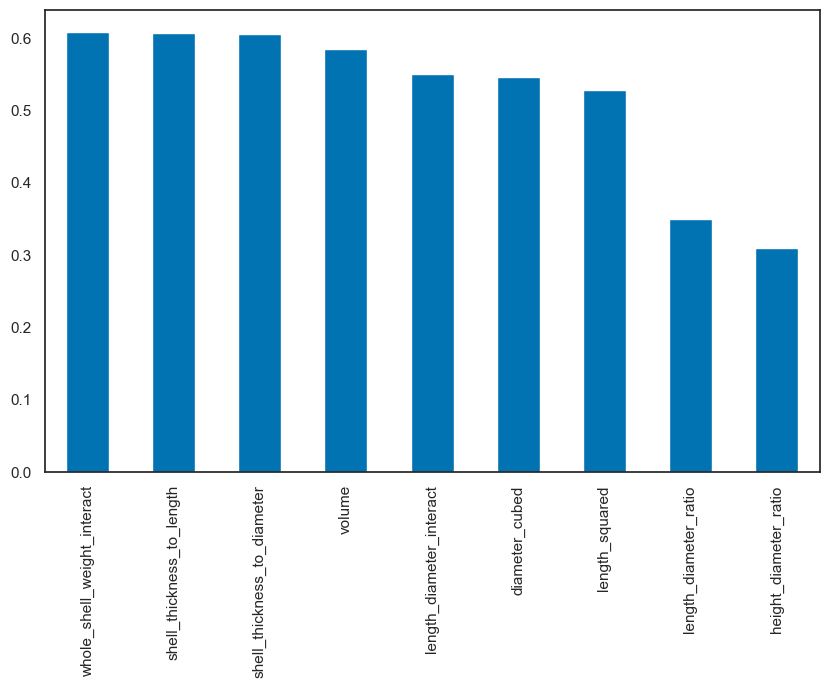

In [20]:
X_num = X.select_dtypes(exclude='object')   

# Calculate mutual information between each feature and the target
mi = mutual_info_regression(X_num, y, random_state=42)
mi = pd.Series(mi, index=X_num.columns)

# Sort the mutual information values in descending order
mi = mi.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
mi.plot.bar()

# Preprocessing

## Pipeline

In [21]:
# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', ColumnTransformer([
        ('minmax', MinMaxScaler(), minmax_list),
        ('standard', StandardScaler(), standard_list),
        ('robust', RobustScaler(), robust_list)
    ])
    )
])

# Preprocessing pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical pipelines
preprocessing = ColumnTransformer([
    ('numerical', numerical_pipeline, X_num.columns),
    ('categorical', categorical_pipeline, X.select_dtypes(include='object').columns)
])


preprocessing

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler',
                                                  ColumnTransformer(transformers=[('minmax',
                                                                                   MinMaxScaler(),
                                                                                   ['whole_shell_weight_interact',
                                                                                    'length_squared']),
                                                                                  ('standard',
                                                                                   StandardScaler(),
                                                                                   ['shell_thickness_to_length',
                                                                                    'shell_thickness_to_diameter',
                                                                                    'length_diameter_interact',
                                                                                    'diameter_cubed']),
                                                                                  ('robust',
                                                                                   RobustScaler(),
                                                                                   ['length_diam...
                                                                                    'volume'])]))]),
                                 Index(['length_diameter_ratio', 'height_diameter_ratio', 'volume',
       'shell_thickness_to_length', 'shell_thickness_to_diameter',
       'length_diameter_interact', 'whole_shell_weight_interact',
       'length_squared', 'diameter_cubed'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['sex'], dtype='object'))])

## Tune Xgboost, LightGBM, Catboost Hyperparameters

### Xgboost

In [23]:
# define a optuna objective function
def objective(trial):
    # define the search space
    params = {
       'n_estimators' : trial.suggest_int('n_estimators',200,5000),
       'learning_rate' : trial.suggest_loguniform('learning_rate',0.01,1),
       'min_child_weight' : trial.suggest_int('min_child_weight',1,10),
       'max_depth' : trial.suggest_int('max_depth',1,50),
       'max_delta_step' : trial.suggest_int('max_delta_step',0,20),
       'subsample' : trial.suggest_uniform('subsample',0.1,1),
       'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0.1,1),
       'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0.1,1),
       'reg_lambda' : trial.suggest_loguniform('reg_lambda',0.01,100),
       'reg_alpha' : trial.suggest_loguniform('reg_alpha',0.01,100),
       'gamma' : trial.suggest_loguniform('gamma',0.01,100),
       'scale_pos_weight' : trial.suggest_loguniform('scale_pos_weight',0.01,500),
    }
    
    # Initialize XGBoost model with suggested hyperparameters
    model = XGBRegressor(**params, random_state=42)    
    
    # fit model
    xgb_pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('xgboost', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = -1 * cross_val_score(xgb_pipe,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_log_error',
                                    n_jobs=-1)
    
    return scores.mean()

In [26]:
# # perform hyperparameter optimization with Optuna
study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective, n_trials=1)

print('\n----------------------------------------\n')
print(f'Best trial: {study_xgboost.best_trial.params}')
print(f'Best score: {study_xgboost.best_value}')

[I 2024-04-04 10:34:45,640] A new study created in memory with name: no-name-c1366d3b-1893-4c22-a0f6-b83e48fea56b


[W 2024-04-04 10:35:16,678] Trial 0 failed with parameters: {'n_estimators': 2243, 'learning_rate': 0.6413802653788633, 'max_depth': 15, 'subsample': 0.46002748285485195, 'colsample_bytree': 0.7209330979404497} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Utilizador\AppData\Local\Temp\ipykernel_20876\625817453.py", line 30, in objective
    scores = -1 * cross_val_score(xgb_pipe,
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 719, in cross_val_score
    cv_results = cross_validate(
  File "c:\Users\Ut

KeyboardInterrupt: 

In [33]:
#study_xgboost.best_params

In [34]:
best_params_xgboost = {
    'n_estimators': 1814,
    'max_depth': 7,
    'min_child_weight': 3.715778439645031,
    'learning_rate': 0.023500239618848437,
    'subsample': 0.9995715820744159,
    'gamma': 0.5761570478966592,
    'colsample_bytree': 0.37054772212482134,
    'colsample_bylevel': 0.8684769327569596,
    'colsample_bynode': 0.976971297407485
}

In [35]:
# Initialize XGBoost model with best hyperparameters
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Fit the model
xgb_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('xgboost', model_xgb)
])

xgb_pipe.fit(X, y)

xgb_pipe

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

### Lightlgm

In [36]:
# define a optuna objective function
def objective(trial):
    # define the search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'learning_rate' = trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),    
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'force_col_wise': True
    }
    
    # Initialize XGBoost model with suggested hyperparameters
    model = LGBMRegressor(**params)
    
    # fit model
    lgm_pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('lightlgm', model)
    ])
    
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = -1 * cross_val_score(lgm_pipe,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_log_error',
                                    n_jobs=-1)

    
    return scores.mean()

In [37]:
# perform hyperparameter optimization with Optuna
#study_lightlgm = optuna.create_study(direction='minimize')
#study_lightlgm.optimize(objective, n_trials=100)

#print('\n----------------------------------------\n')
#print(f'Best trial: {study_lightlgm.best_trial.params}')
#print(f'Best score: {study_lightlgm.best_value}')

In [38]:
#study_lightlgm.best_params

In [39]:
best_params_lgm = {'n_estimators': 900,
                    'reg_alpha': 0.003275377825572326,
                    'reg_lambda': 3.675188637149269,
                    'colsample_bytree': 0.6,
                    'subsample': 0.6,
                    'learning_rate': 0.008,
                    'max_depth': 20,
                    'num_leaves': 219,
                    'min_child_samples': 96,
                    'min_data_per_groups': 7,
                    'force_row_wise': True}

In [40]:
model_lgm = LGBMRegressor(random_state=42, n_jobs=-1)

lgm_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('lightlgm', model_lgm)
])

lgm_pipe.fit(X, y)

lgm_pipe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18991
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 7828
[LightGBM] [Info] Start training from score 9.696794


Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_to_length',
                                                                                                    'shell_thickness_to_diameter',
                                                                                                    'length_diameter_interact',
                                                                                                    'diameter_cubed']),
                                                                                                  ('robust',
                                                                                                   RobustScaler(),
                                                                                                   ['length_diameter_ratio',
                                                                                                    'height_diameter_ratio',
                                                                                                    'volume'])]))])),
                                                ('categorical',
                                                 Pipeline(steps=[('encoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('lightlgm', LGBMRegressor(n_jobs=-1, random_state=42))])

### Catboost

In [41]:
# # define a optuna objective function
# def objective(trial):
    
#     # define the search space
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000, 100),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'random_strength': trial.suggest_float('random_strength', 0.1, 1),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
#         'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
#         'subsample': trial.suggest_float('subsample', 0.5, 1)
#     }
    
#     # Initialize XGBoost model with suggested hyperparameters
#     model = CatBoostRegressor(**params)
    
#     # fit model
#     cat_pipe = Pipeline([
#         ('preprocessing', preprocessing),
#         ('catboost', model)
#     ])
    
#     scores = -1 * cross_val_score(cat_pipe,
#                                     X,
#                                     y,
#                                     cv=KFold(n_splits=5, shuffle=True, random_state=42),
#                                     scoring='neg_root_mean_squared_log_error',
#                                     n_jobs=-1)

    
#     return scores.mean()

In [42]:
# perform hyperparameter optimization with Optuna
#study_catboost = optuna.create_study(direction='minimize')
#study_catboost.optimize(objective, n_trials=100)

#print('\n----------------------------------------\n')
#print(f'Best trial: {study_catboost.best_trial.params}')
#print(f'Best score: {study_catboost.best_value}')

In [43]:
#study_catboost.best_params

In [44]:
best_params_catboost = {'iterations': 700,
                        'colsample_bylevel': 0.8534686279282355,
                        'learning_rate': 0.08164537566057216,
                        'random_strength': 0.8408653469388907,
                        'depth': 9,
                        'l2_leaf_reg': 0.7820872728034921,
                        'boosting_type': 'Ordered',
                        'subsample': 0.6327177418601386,
                        'verbose': 0}

In [47]:
model_catboost = CatBoostRegressor(random_state=42)

cat_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('catboost', model_catboost)
])

cat_pipe.fit(X, y)

cat_pipe

Learning rate set to 0.083448
0:	learn: 3.0434733	total: 592ms	remaining: 9m 51s
1:	learn: 2.9246918	total: 972ms	remaining: 8m 4s
2:	learn: 2.8172358	total: 1.33s	remaining: 7m 23s
3:	learn: 2.7184924	total: 1.7s	remaining: 7m 4s
4:	learn: 2.6341164	total: 2.06s	remaining: 6m 50s
5:	learn: 2.5582169	total: 2.42s	remaining: 6m 41s
6:	learn: 2.4904518	total: 2.79s	remaining: 6m 36s
7:	learn: 2.4308847	total: 3.15s	remaining: 6m 31s
8:	learn: 2.3753606	total: 3.52s	remaining: 6m 27s
9:	learn: 2.3294277	total: 3.88s	remaining: 6m 24s
10:	learn: 2.2847967	total: 4.24s	remaining: 6m 21s
11:	learn: 2.2496053	total: 4.61s	remaining: 6m 19s
12:	learn: 2.2147360	total: 4.97s	remaining: 6m 17s
13:	learn: 2.1858534	total: 5.34s	remaining: 6m 16s
14:	learn: 2.1575380	total: 5.72s	remaining: 6m 15s
15:	learn: 2.1336248	total: 6.1s	remaining: 6m 14s
16:	learn: 2.1113223	total: 6.46s	remaining: 6m 13s
17:	learn: 2.0913347	total: 6.83s	remaining: 6m 12s
18:	learn: 2.0762452	total: 7.21s	remaining: 6m 

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_to_length',
                                                                                                    'shell_thickness_to_diameter',
                                                                                                    'length_diameter_interact',
                                                                                                    'diameter_cubed']),
                                                                                                  ('robust',
                                                                                                   RobustScaler(),
                                                                                                   ['length_diameter_ratio',
                                                                                                    'height_diameter_ratio',
                                                                                                    'volume'])]))])),
                                                ('categorical',
                                                 Pipeline(steps=[('encoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('catboost',
                 <catboost.core.CatBoostRegressor object at 0x000001AE4E5E4880>)])

In [49]:
model_adaboost = AdaBoostRegressor(random_state=42)

adaboost_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('adaboost', model_adaboost)
])

adaboost_pipe.fit(X, y)

adaboost_pipe

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_to_length',
                                                                                                    'shell_thickness_to_diameter',
                                                                                                    'length_diameter_interact',
                                                                                                    'diameter_cubed']),
                                                                                                  ('robust',
                                                                                                   RobustScaler(),
                                                                                                   ['length_diameter_ratio',
                                                                                                    'height_diameter_ratio',
                                                                                                    'volume'])]))])),
                                                ('categorical',
                                                 Pipeline(steps=[('encoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('adaboost', AdaBoostRegressor(random_state=42))])

In [52]:
model_rf = RandomForestRegressor(n_estimators=100,
                                 min_samples_leaf=8,
                                 max_features=5, 
                                 random_state=42,
                                 n_jobs=-1)

rf_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('randomforest', model_rf)
])

rf_pipe.fit(X, y)

rf_pipe

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_...
                                                                                                    'shell_thickness_to_diameter',
                                                                                                    'length_diameter_interact',
                                                                                                    'diameter_cubed']),
                                                                                                  ('robust',
                                                                                                   RobustScaler(),
                                                                                                   ['length_diameter_ratio',
                                                                                                    'height_diameter_ratio',
                                                                                                    'volume'])]))])),
                                                ('categorical',
                                                 Pipeline(steps=[('encoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('randomforest',
                 RandomForestRegressor(max_features=5, min_samples_leaf=8,
                                       n_jobs=-1, random_state=42))])

In [54]:
model_knr = KNeighborsRegressor(n_neighbors=50, 
                                n_jobs=-1)   

knf_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('kneighbors', model_knr)
])

knf_pipe.fit(X, y)

knf_pipe

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_to_length',
                                                                                                    'shell_thickness_to_diameter',
                                                                                                    'length_diameter_interact',
                                                                                                    'diameter_cubed']),
                                                                                                  ('robust',
                                                                                                   RobustScaler(),
                                                                                                   ['length_diameter_ratio',
                                                                                                    'height_diameter_ratio',
                                                                                                    'volume'])]))])),
                                                ('categorical',
                                                 Pipeline(steps=[('encoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('kneighbors', KNeighborsRegressor(n_jobs=-1, n_neighbors=50))])

In [56]:
# Nystroem transformer + Ridge

nystroem = Pipeline([
    ('preprocessing', preprocessing),
    ('nystroem', Nystroem(n_components=500 ,random_state=42)),
    ('ridge', Ridge(alpha=0.1, random_state=42))
])

nystroem.fit(X, y)

nystroem

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('minmax',
                                                                                                   MinMaxScaler(),
                                                                                                   ['length',
                                                                                                    'height',
                                                                                                    'shucked_weight',
                                                                                                    'viscera_weight',
                                                                                                    'shell_weight',
                                                                                                    'whole_shell_weight_interact',
                                                                                                    'length_squared']),
                                                                                                  ('standard',
                                                                                                   StandardScaler(),
                                                                                                   ['diameter',
                                                                                                    'whole_weight',
                                                                                                    'shell_thickness_...
                                                                                                    'shell_thickness_to_diameter',
                                                                                                    'length_diameter_interact',
                                                                                                    'diameter_cubed']),
                                                                                                  ('robust',
                                                                                                   RobustScaler(),
                                                                                                   ['length_diameter_ratio',
                                                                                                    'height_diameter_ratio',
                                                                                                    'volume'])]))])),
                                                ('categorical',
                                                 Pipeline(steps=[('encoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('nystroem', Nystroem(n_components=500, random_state=42)),
                ('ridge', Ridge(alpha=0.1, random_state=42))])

In [64]:
# use voting regressor to combine the base models

voting_regressor = VotingRegressor([
    ('xgb', xgb_pipe),
    ('lgm', lgm_pipe),
    ('cat', cat_pipe),
    ('adaboost', adaboost_pipe),
    ('randomforest', rf_pipe),
    ('kneighbors', knf_pipe),
    ('nystroem', nystroem)
    
])

voting_regressor.fit(X, y)

voting_regressor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.299016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18991
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 7828
[LightGBM] [Info] Start training from score 9.696794
Learning rate set to 0.083448
0:	learn: 3.0434733	total: 499ms	remaining: 8m 18s
1:	learn: 2.9246918	total: 915ms	remaining: 7m 36s
2:	learn: 2.8172358	total: 1.31s	remaining: 7m 16s
3:	learn: 2.7184924	total: 1.71s	remaining: 7m 6s
4:	learn: 2.6341164	total: 2.12s	remaining: 7m 1s
5:	learn: 2.5582169	total: 2.51s	remaining: 6m 56s
6:	learn: 2.4904518	total: 2.91s	remaining: 6m 52s
7:	learn: 2.4308847	total: 3.3s	remaining: 6m 49s
8:	learn: 2.3753606	total: 3.7s	remaining: 6m 47s
9:	learn: 2.3294277	total: 4.12s	remaining: 6m 47s
10:	learn: 2.2847967	total: 4.53s	remaining: 6m 47s
11:

VotingRegressor(estimators=[('xgb',
                             Pipeline(steps=[('preprocessing',
                                              FeatureUnion(transformer_list=[('numerical',
                                                                              Pipeline(steps=[('scaler',
                                                                                               ColumnTransformer(transformers=[('minmax',
                                                                                                                                MinMaxScaler(),
                                                                                                                                ['length',
                                                                                                                                 'height',
                                                                                                                                 'shucked_weight',
                                                                                                                                 'viscera_weight',
                                                                                                                                 'shell_weight',
                                                                                                                                 'whole_shell_weight_interact',
                                                                                                                                 'length_squared']),
                                                                                                                               ('standard',
                                                                                                                                StandardScaler(),
                                                                                                                                ['diamete...
                                                                                                                                 'shell_thickness_to_diameter',
                                                                                                                                 'length_diameter_interact',
                                                                                                                                 'diameter_cubed']),
                                                                                                                               ('robust',
                                                                                                                                RobustScaler(),
                                                                                                                                ['length_diameter_ratio',
                                                                                                                                 'height_diameter_ratio',
                                                                                                                                 'volume'])]))])),
                                                                             ('categorical',
                                                                              Pipeline(steps=[('encoder',
                                                                                               OneHotEncoder(handle_unknown='ignore'))]))])),
                                             ('nystroem',
                                              Nystroem(n_components=500,
                                                       random_state=42)),
                                             ('ridge',
                                              Ridge(alpha=0.1,
                                                    random_state=42))]))])

In [ ]:
voting_regressor.predict(test)

## Predictions

In [71]:
y_pred_lgm = lgm_pipe.predict(test)

y_pred_lgm[:10]

ValueError: columns are missing: {'height', 'whole_shell_weight_interact', 'whole_weight', 'shell_weight', 'diameter_cubed', 'length', 'volume', 'shell_thickness_to_diameter', 'diameter', 'length_diameter_ratio', 'shell_thickness_to_length', 'length_squared', 'height_diameter_ratio', 'viscera_weight', 'length_diameter_interact', 'shucked_weight'}

In [31]:
y_pred_xgb = xgb_pipe.predict(test)

y_pred_xgb[:10]

array([ 9.920566 ,  9.698488 , 10.185683 , 10.208255 ,  7.6128564,
        9.400499 , 11.24469  ,  6.2102313,  7.9569845, 11.164836 ],
      dtype=float32)

In [32]:
y_pred_cat = cat_pipe.predict(test)

y_pred_cat[:10]

array([ 9.3682787 ,  9.65729117, 10.30077544, 10.344683  ,  7.55395208,
        9.51603014, 11.59426594,  6.33973107,  7.90227174, 11.08843279])

In [65]:
# get feature importance for all models
# feature_importance_xgb = xgb_pipe.named_steps['xgboost'].feature_importances_

# feature_importance_lgm = lgm_pipe.named_steps['lightlgm'].feature_importances_

# feature_importance_cat = cat_pipe.named_steps['catboost'].feature_importances_

# # get feature names
# feature_names = preprocessing.named_transformers_['categorical'].named_steps['encoder'].get_feature_names_out()

# feature_names = np.concatenate([X_num.columns, feature_names])

# # create a DataFrame with feature importance
# feature_importance_df_xgb = pd.DataFrame(feature_importance_xgb, index=feature_names, columns=['importance_xgb']).sort_values(by='importance_xgb', ascending=False)

# feature_importance_df_lgm = pd.DataFrame(feature_importance_lgm, index=feature_names, columns=['importance_lgm']).sort_values(by='importance_lgm', ascending=False)

# feature_importance_df_cat = pd.DataFrame(feature_importance_cat, index=feature_names, columns=['importance_cat']).sort_values(by='importance_cat', ascending=False)

# # merge all feature importance DataFrames
# feature_importance_df = pd.concat([feature_importance_df_xgb, feature_importance_df_lgm, feature_importance_df_cat], axis=1)

# # calculate the mean importance
# feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)

# # sort the DataFrame by mean importance
# feature_importance_df = feature_importance_df.sort_values(by='mean_importance', ascending=False)

# # plot the feature importance
# plt.figure(figsize=(10, 10))
# sns.barplot(x='mean_importance', y=feature_importance_df.index, data=feature_importance_df, palette='viridis')
# plt.title('Feature Importance')


In [70]:
# create a voting regressor
ensemble = StackingRegressor(
    estimators=[
        ('xgb', xgb_pipe),
        ('lgm', lgm_pipe),
        ('cat', cat_pipe),
        ('adaboost', adaboost_pipe),
        ('randomforest', rf_pipe),
        ('kneighbors', knf_pipe),
        ('nystroem', nystroem),
        ('voting', voting_regressor)
    ],
    final_estimator=Ridge(alpha=0.1, random_state=42),
    n_jobs=-1
)

X = train.drop('rings', axis=1)
y = train['rings']

ensemble.fit(X, y)

ensemble

ValueError: cannot set WRITEABLE flag to True of this array

In [75]:
# Access the coefficients of the final estimator (linear regression)
coefficients = ensemble.final_estimator_.feature_importances_

# Print the coefficients corresponding to each base estimator
for estimator_name, coefficient in zip(['xgb', 'lgbm', 'cat','voting_regressor'], coefficients):
    print(f"{estimator_name}: {coefficient}")

xgb: 0.03487683697625366
lgbm: 0.18277931346206538
cat: 0.10482730972248033
voting_regressor: 0.6775165398392007


In [72]:
y_pred_ensemble = ensemble.predict(test)

y_pred_ensemble[:10]

AttributeError: 'StackingRegressor' object has no attribute 'estimators_'

In [78]:
# fit the model
y_pred_ensemble = ensemble.predict(test)

y_pred_ensemble[:10]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


array([ 9.61195462,  9.73570678,  9.99629005, 10.52886087,  7.62692867,
        9.40636176, 11.32383742,  6.38441502,  8.00237116, 10.95564064])

In [79]:
# Create a DataFrame for the submission data
submission_data = pd.DataFrame(y_pred_ensemble, index=test.index, columns=['Rings'])

submission_data

,Rings
id,
90615,9.611955
90616,9.735707
90617,9.996290
90618,10.528861
90619,7.626929
...,...
151021,6.425845
151022,9.606421
151023,12.648292


In [94]:
train['Rings'].value_counts().sort_index()

Rings
1        25
2        29
3       386
4      1402
5      2862
6      5411
7      9008
8     14499
9     17465
10    12464
11     8407
12     4719
13     4074
14     2507
15     2072
16     1439
17     1175
18      848
19      639
20      507
21      255
22      108
23      180
24       29
25       22
26       18
27       41
29       24
Name: count, dtype: int64

In [80]:
# Save the DataFrame to a CSV file

submission_data
submission_data.to_csv('output/submission_stacking_v1.csv')

In [84]:
#count rings in test set
test.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


Stuff to check and have fun 😃:
* more models to check - SVM, Ridge, Lasso, Elastic, other boosting
* feature engineering
* class 28 not represented in test - do not have outputs in that range
* ensemble methods - ok